Brayan Padilla - Gustavo Molina - Didier Vargas

link edge impulse: https://studio.edgeimpulse.com/studio/535414/acquisition/training?page=1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Se cargan las diferentes dependencias necesarias
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython import display

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
   # sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
   # wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

(44100,)


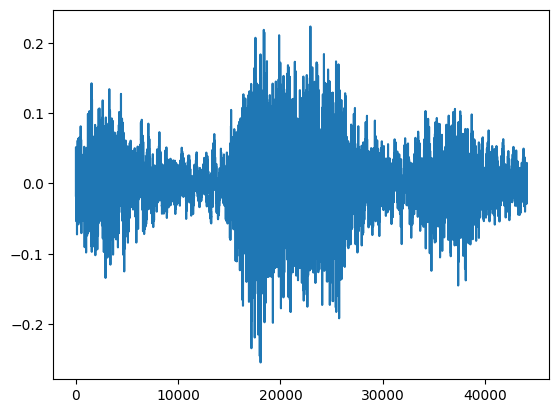

In [ ]:
# Ejemplo de carga de un archivo
RutaFile="/content/gdrive/MyDrive/audio_bird/training/gallito_peruano.Gallito de las rocas peruano.XC175046 - Gallito de las rocas peruano - Rupicola peruvianus.wav.5a2epo22.ingestion-d656d7f45-l8kzc.s18.wav.5a312m08.ingestion-d656d7f45-sj6ww.wav"
wave = load_wav_16k_mono(RutaFile)
print(wave.shape)
plt.plot(wave)
plt.show()



In [ ]:
def preprocess(wave):
    #wav = wave[:32000]
    wav = wave[:16000]
    #zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
   # wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

In [ ]:
espectrograma= preprocess(wave)
print('Waveform shape:', wave.shape)
print('Spectrogram shape:', espectrograma.shape)
print('Audio playback')
display.display(display.Audio(wave, rate=16000))

Waveform shape: (44100,)
Spectrogram shape: (124, 129)
Audio playback


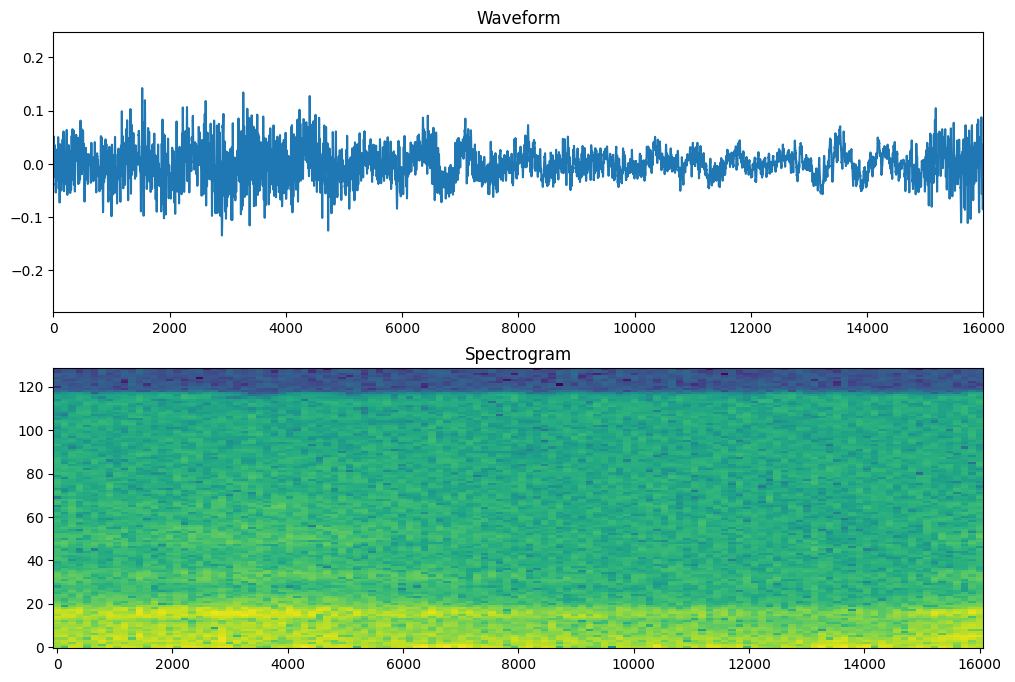

In [ ]:
def plot_spectrogram(espectrograma, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(espectrograma.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(espectrograma), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(wave.shape[0])
axes[0].plot(timescale, wave.numpy())
axes[0].set_title('Waveform')
#axes[0].set_xlim([0, 32000])
axes[0].set_xlim([0, 16000])
plot_spectrogram(espectrograma.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
import os

directory = "/content/gdrive/MyDrive/audio_bird/training/"
files = os.listdir(directory)
print("Archivos en la carpeta:", files)

Archivos en la carpeta: ['ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s14.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s9.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s6.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s11.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s16.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s15.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s2.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s17.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s13.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18.43.42.wav.5a3c5uei.ingestion-d656d7f45-l8kzc.s10.wav', 'ruido.WhatsApp Audio 2024-10-14 at 18

In [ ]:
for file in files:
    if file.endswith(".wav"):
        try:
            RutaFile = os.path.join(directory, file)
            wave = load_wav_16k_mono(RutaFile)  # O la función que estés usando
        except Exception as e:
            print(f"Error al cargar {file}: {e}")
    else:
        print(f"{file} no es un archivo WAV.")

In [ ]:
# Se cargan los diferentes archivos *.json que se van a usar en el proceso
# de entrenamiento
import os
directory = '/content/gdrive/MyDrive/audio_bird/training/'
files = os.listdir(directory)
files.sort()
cantidadFiles = len(files)
# Variable donde se almacenaron los datos leidos de los archivos *.json
#Datos=np.zeros((cantidadFiles*624,3))
Datos=np.zeros((cantidadFiles,124,129))
i = 0
for file in files:
  RutaFile=directory + file
  wave = load_wav_16k_mono(RutaFile)
  espectrograma= preprocess(wave)
  Datos[i,:,:]=espectrograma
  i+=1
print(Datos.shape)
Xtrain=tf.expand_dims(Datos, axis=3)
print(Xtrain.shape)



(655, 124, 129)
(655, 124, 129, 1)


In [ ]:
YtrainIni=np.zeros((655,1))
for i in range(148):
    YtrainIni[i]=0

for i in range(148,283):
    YtrainIni[i]=1

for i in range(283,415):
    YtrainIni[i]=2

for i in range(415,550):
    YtrainIni[i]=3

for i in range(550,655):
    YtrainIni[i]=4

print(YtrainIni)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

In [ ]:
Ytrain= keras.utils.to_categorical(YtrainIni)
print(Ytrain)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)                   │ (None, 124, 129, 16)        │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 124, 129, 32)        │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 124, 129, 32)        │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 124, 129, 64)        │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 124, 129, 64)        │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 62, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 257920)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │       1,289,605 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,412,949 (5.39 MB)

 Trainable params: 1,412,949 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

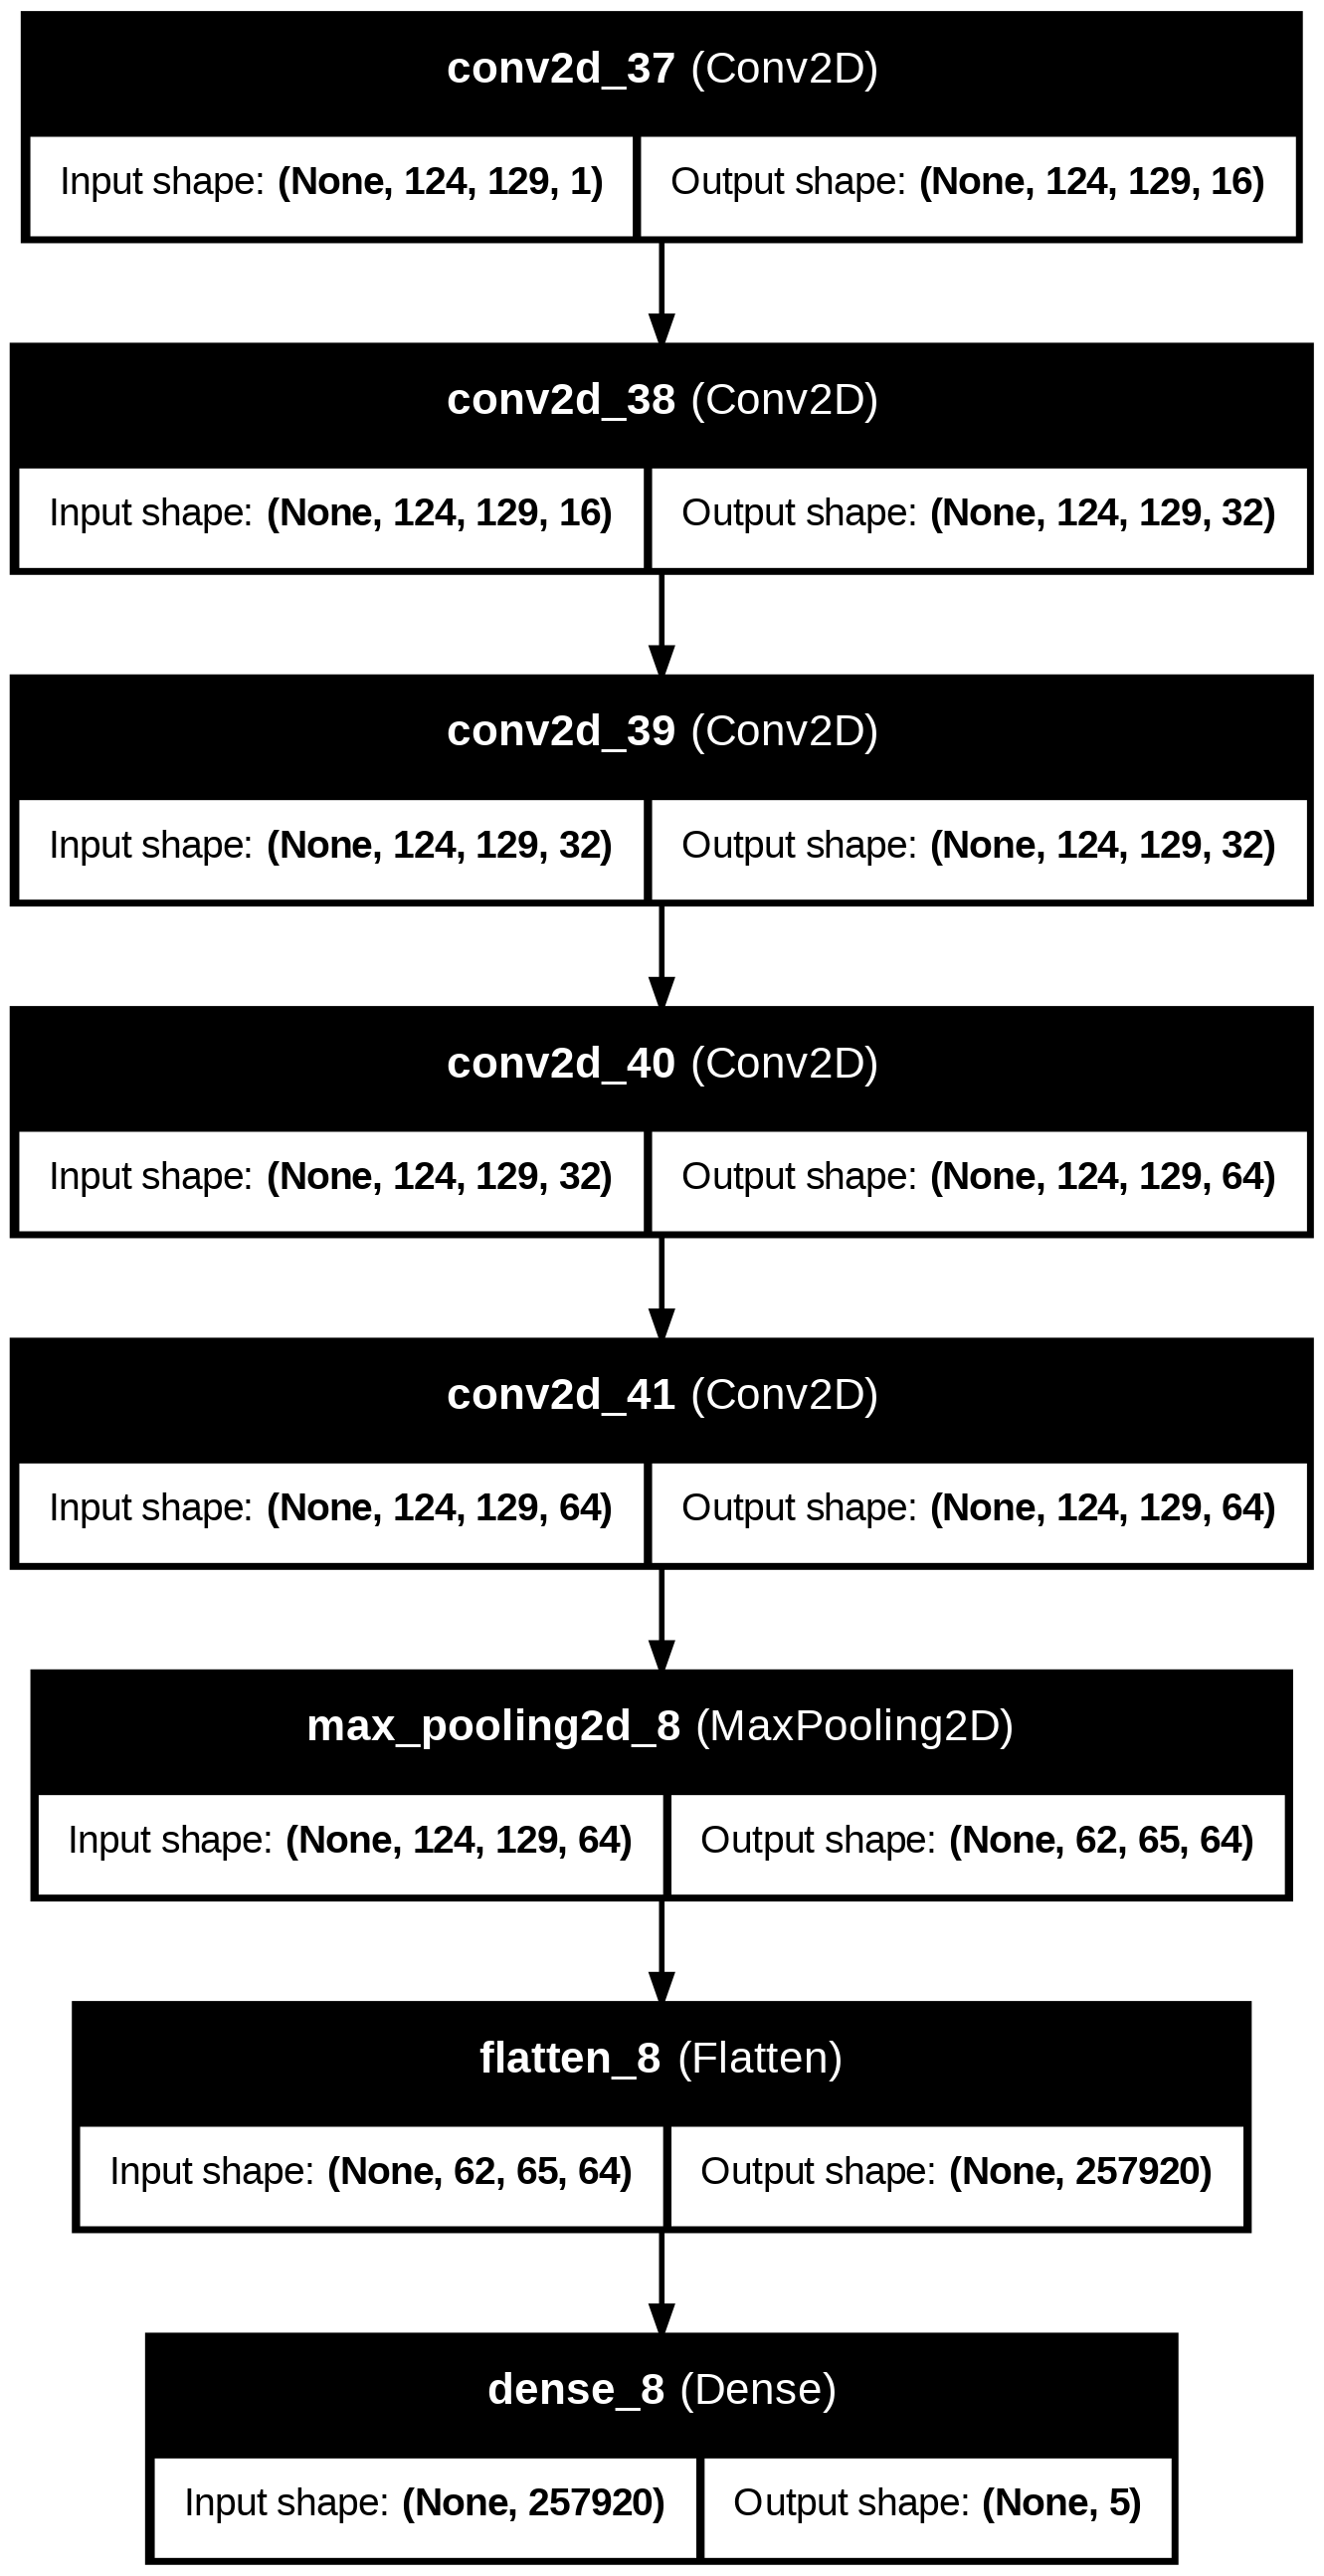

In [ ]:

#Definición del modelo
modelo = keras.models.Sequential()
modelo.add(keras.layers.Conv2D(16, 4, activation="relu",padding="same", input_shape=(124,129,1)))
modelo.add(keras.layers.Conv2D(32, 4, activation="relu",padding="same"))
modelo.add(keras.layers.Conv2D(32, 4, activation="relu",padding="same"))
modelo.add(keras.layers.Conv2D(64, 4, activation="relu",padding="same"))
modelo.add(keras.layers.Conv2D(64, 4, activation="relu",padding="same"))
modelo.add(keras.layers.MaxPooling2D(pool_size=2,strides=2, padding='same'))
modelo.add(keras.layers.Flatten())
modelo.add(keras.layers.Dense(5, activation = 'softmax'))
modelo.summary()

keras.utils.plot_model(modelo, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

In [ ]:
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = modelo.fit(Xtrain,Ytrain, epochs=20,batch_size=None)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 627ms/step - accuracy: 0.4662 - loss: 1.2194
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.7775 - loss: 0.7305
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9010 - loss: 0.3340
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9243 - loss: 0.2555
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9551 - loss: 0.1280
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9480 - loss: 0.1267
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.9735 - loss: 0.0957
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.9657 - loss: 0.1671
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9757 - loss: 0.0759
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9753 - loss: 0.1339
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9736 - loss: 0.0678
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/st

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.9968 - loss: 0.0095


[0.025448191910982132, 0.989313006401062]

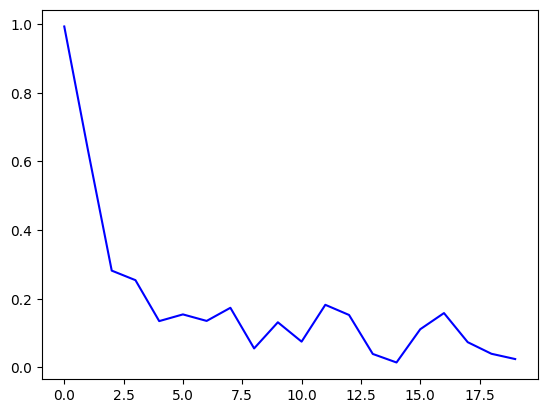

In [ ]:
plt.plot(history.history["loss"],'b')
modelo.evaluate(Xtrain, Ytrain)

In [ ]:
# Se cargan los diferentes archivos *.json que se van a usar en el proceso
# de testeo

import os
directory = '/content/gdrive/MyDrive/audio_bird/testing/'
files = os.listdir(directory)
files.sort()

cantidadFiles = len(files)

DatosVal=np.zeros((cantidadFiles,124,129))
i = 0
for file in files:
  RutaFile=directory + file
  wave = load_wav_16k_mono(RutaFile)
  espectrograma= preprocess(wave)
  DatosVal[i,:,:]=espectrograma
  i+=1
print(DatosVal.shape)
XVal=tf.expand_dims(DatosVal, axis=3)
print(XVal.shape)

(189, 124, 129)
(189, 124, 129, 1)


In [ ]:
YValIni=np.zeros((189,1))
for i in range(44):
    YValIni[i]=0

for i in range(44,88):
    YValIni[i]=1

for i in range(88,124):
    YValIni[i]=2

for i in range(124,158):
    YValIni[i]=3

for i in range(158,189):
    YValIni[i]=4

print(YValIni)
YVal= keras.utils.to_categorical(YValIni)

print(YVal)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [2.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [4.]
 [4.]
 [4.]
 [4.]
 [4.]
 [4.]
 [4.]
 [4.]
 [4.

In [ ]:
modelo.evaluate(XVal, YVal)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 791ms/step - accuracy: 0.8500 - loss: 2.0472


[1.514317274093628, 0.841269850730896]

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
              precision    recall  f1-score   support

           0       0.79      0.86      0.83        44
           1       0.89      0.77      0.83        44
           2       0.97      0.94      0.96        36
           3       0.71      0.74      0.72        34
           4       0.85      0.90      0.88        31

    accuracy                           0.84       189
   macro avg       0.84      0.84      0.84       189
weighted avg       0.85      0.84      0.84       189

[[38  1  0  1  4]
 [ 1 34  1  7  1]
 [ 0  2 34  0  0]
 [ 8  1  0 25  0]
 [ 1  0  0  2 28]]


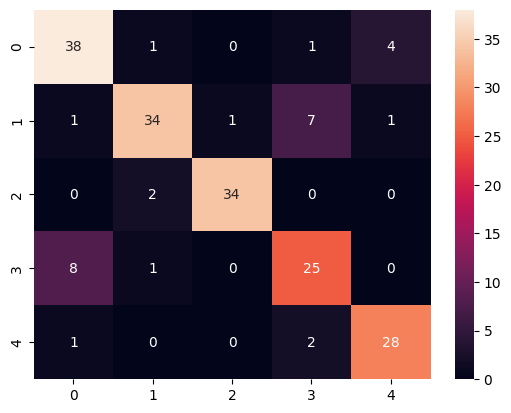

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ypredic=modelo.predict(XVal)

y_test_class = np.argmax(YVal,axis=1)
y_pred_class = np.argmax(ypredic,axis=1)

#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class)) # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)
# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")